<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Book Version](https://www.learnpytorch.io/02_pytorch_classification/) |
[View Source Code](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb) | [View Slides](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/02_pytorch_classification.pdf) | [Watch Video Walkthrough](https://youtu.be/Z_ikDlimN6A?t=30691)

In [1]:

from IPython.display import clear_output
import torch
# example  of timestamp used in youtube
#chapter 61 at 8:41:43  hour + 3600 *(min/60) + sec
# the video ID I am watching is https://youtu.be/V_xro1bcAuA&t=timestamp
def get_timestamp(h:torch.int,m:torch.int,s:torch.int):
    return(3600 * h + (60*m) + s)
#(8. + (41/60)) * 3600 + 43


# 02. PyTorch Neural Network Classification

## What is a classification problem?

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:

| Problem type | What is it? | Example |
| ----- | ----- | ----- |
| **Binary classification** | Target can be one of two options, e.g. yes or no | Predict whether or not someone has heart disease based on their health parameters. |
| **Multi-class classification** | Target can be one of more than two options | Decide whether a photo is of food, a person or a dog. |
| **Multi-label classification** | Target can be assigned more than one option | Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosophy). |

<div align="center">
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-different-classification-problems.png" alt="various different classification in machine learning such as binary classification, multiclass classification and multilabel classification" width=900/>
</div>
    
Classification, along with regression (predicting a number, covered in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/)) is one of the most common types of machine learning problems.

In this notebook, we're going to work through a couple of different classification problems with PyTorch. 

In other words, taking a set of inputs and predicting what class those set of inputs belong to.




## 0. Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

Of course, this ingredient list of classification neural network components will vary depending on the problem you're working on.

But it's more than enough to get started.

We're going to get hands-on with this setup throughout this notebook.

## 1. Make classification data and get it ready

Let's begin by making some data.

We'll use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) method from Scikit-Learn to generate two circles with different coloured dots. 

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03, # add some noise
                    random_state=42 # for reproducability
                  )

Alright, now let's view the first 5 `X` and `y` values

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


Looks like there's two `X` values per one `y` value. 

Let's keep following the data explorer's motto of *visualize, visualize, visualize* and put them into a pandas DataFrame.

In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


It looks like each pair of `X` features (`X1` and `X2`) has a label (`y`) value of either 0 or 1.

This tells us that our problem is **binary classification** since there's only two options (0 or 1).

How many values of each class are there?

In [5]:
# check the different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

500 each, nice and balanced.

Let's plot them.

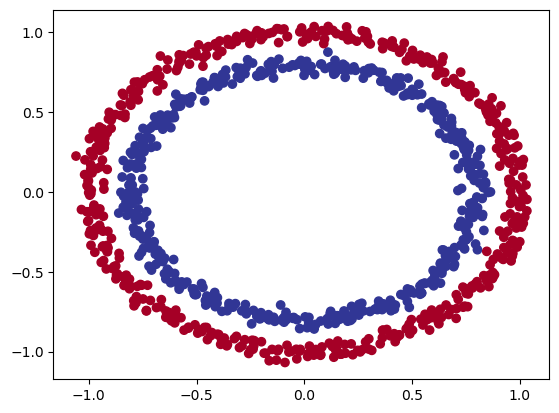

In [6]:
# visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

[Chapter 64](https://youtu.be/V_xro1bcAuA&t=32980)

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# view the first sample of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values of one sample of X; {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values of one sample of X; [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into Tensors and create train/test splits

In [10]:
import torch
type(X), X.dtype, type(y), y.dtype

(numpy.ndarray, dtype('float64'), numpy.ndarray, dtype('int64'))

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5],  y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
# Turn data into train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2, # 20% of data as split
                                                    random_state=42) # seed for the random splitting

In [13]:
len(X_train), len(X_test)

(800, 200)

## 2. Building a model

[Chapter 65](https://youtu.be/V_xro1bcAuA&t=33699)

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Detup device agnostic code so our code will run on and accelerator (GPU) if there is one.
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create a train and test loop

In [14]:
#import Pytorch and nn
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

[Chapter 66](https://youtu.be/V_xro1bcAuA&t=33958) 9:25:58

Create a model
1. Subclasses nn.Module
2. Create 2 nn.Linear() layers that are capable of handling the shape of our data
3. Define a forward() method (required by nn.Module) performs forward calculations
4. Instanciate the class and send it to the target device

In [15]:
# 1. Construction
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 Linear layers
        self.layer_1= nn.Linear(in_features=2, out_features=5) # upscale to 5 quasi hidden layer
        self.layer_2= nn.Linear(in_features=5, out_features=1)
    # 3. define a forward method
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # layer 1 -> layer 2 -> output

#4. Instantiate the class
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cuda', index=0)

[Chapter 67](https://youtu.be/V_xro1bcAuA&t=34617) (9:36:57)

[Tensorflow playground](https://playground.tensorflow.org/) |
[Deep Learning Book](https://www.deeplearningbook.org/)

In [17]:
# 2. Rework above model using Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0801,  0.5928],
                      [-0.2050,  0.0720],
                      [-0.6681,  0.6141],
                      [-0.1608, -0.4843],
                      [ 0.3381,  0.6739]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1859, -0.2861, -0.5400, -0.0826,  0.3206], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.2418,  0.0394, -0.0513,  0.2416,  0.2661]], device='cuda:0')),
             ('1.bias', tensor([-0.1620], device='cuda:0'))])

In [19]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f"Length of prediction: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
    print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
    print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")


Length of prediction: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[ 0.0639],
        [ 0.1356],
        [-0.1316],
        [ 0.1193],
        [-0.1435],
        [-0.0996],
        [ 0.1118],
        [ 0.0566],
        [-0.1308],
        [ 0.1403]], device='cuda:0')


### 2.1 Setup Loss function and optimizer
Which loss function or which optimizer

This is problem specific
For binary classification

In [20]:
# Seetup the loss fcn and optimizer#loss_fcn = nn.BCELoss() # expects input to have passed thru a sigmoid layer first
loss_fcn = nn.BCEWithLogitsLoss() # built in sigmoid function

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [21]:
# calculate accuracy - percentage of correct answers num_right/total
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train model 

[Chapter 70](https://youtu.be/V_xro1bcAuA&t=36726) 

Going from model logits to prediction probabilities to prediction labels.  (10:12:06)

**Lyrics**

1. Let's train!
2. For an epoch in a range
3. Call model dot train
4. Do the forward pass
5. Calculate the loss
6. Optimizer zero grad
7. Lossssss backward
8. Optimizer step step step

Test time!

1. Call model dot eval
2. With torch inference mode
3. Do the forward pass
4. Calculate the loss
5. Print out what's happenin'

Don't forget to save

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw Logits
We can convert these **Logits** into probabilities  by passing them to some activation function (sigmoid)
Then we can turn to labels by rounding or using SoftMax()

In [22]:
# view  the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
X_test.shape, X_test[:5], y_logits

(torch.Size([200, 2]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438]]),
 tensor([[ 0.0639],
         [ 0.1356],
         [-0.1316],
         [ 0.1193],
         [-0.1435]], device='cuda:0'))

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [24]:
# Use sigmoid on the logits to turn into probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5160],
        [0.5338],
        [0.4671],
        [0.5298],
        [0.4642]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them

* y_pred_probs >= 0.5, y = (class)1
* y_pred_probs < 0.5, y = (class)0


In [25]:
# find the predicted labels
y_preds =torch.round(y_pred_probs)

# in full logits -> probs -> labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_test[:5], y_preds.squeeze(), y_pred_labels.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


(tensor([1., 0., 1., 0., 1.]),
 tensor([1., 1., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 0., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>))

**Let's train**

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

## put data to target
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test   = X_test.to(device), y_test.to(device)
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [27]:

# Build train and evaluation loop
for epoch in range(epochs):
    # call model dot train
    model_0.train()
    
    # 1. Do the forward pass
    y_logits = model_0(X_train).squeeze()

    # in full logits -> probs -> labels
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. calculate loss accuracy
    # Note: BCEWithLogitsLoss expects raw logits
    # whereas BCELoss  expects prediction probabilities
    loss = loss_fcn(y_logits, y_train)  
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()
    # 5. optimizer.step
    optimizer.step()

    # Testing
    model_0.eval
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate loss accuracy (need logits, not probabilities)
        test_loss = loss_fcn(test_logits.squeeze(), y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
     
    # print out whats happinin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Acc {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69401, Acc: 50.38% | Test loss: 0.69931, Acc 45.00%
Epoch: 10 | Loss: 0.69370, Acc: 50.88% | Test loss: 0.69863, Acc 45.50%
Epoch: 20 | Loss: 0.69351, Acc: 50.88% | Test loss: 0.69808, Acc 47.00%
Epoch: 30 | Loss: 0.69338, Acc: 51.00% | Test loss: 0.69763, Acc 47.00%
Epoch: 40 | Loss: 0.69329, Acc: 50.62% | Test loss: 0.69725, Acc 45.50%
Epoch: 50 | Loss: 0.69323, Acc: 50.62% | Test loss: 0.69693, Acc 45.50%
Epoch: 60 | Loss: 0.69318, Acc: 50.75% | Test loss: 0.69666, Acc 45.50%
Epoch: 70 | Loss: 0.69314, Acc: 50.88% | Test loss: 0.69642, Acc 45.50%
Epoch: 80 | Loss: 0.69311, Acc: 51.00% | Test loss: 0.69623, Acc 46.00%
Epoch: 90 | Loss: 0.69309, Acc: 50.62% | Test loss: 0.69606, Acc 45.50%


## 4. Making predictions and evaluate the model

From the metrics, it appears that it isn't learning anything

So, to inspect it, let's make some predictions and inspect

So in other words, "Visualize, Visualize, Visualize" 

To do so, we'll import a function

In [28]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


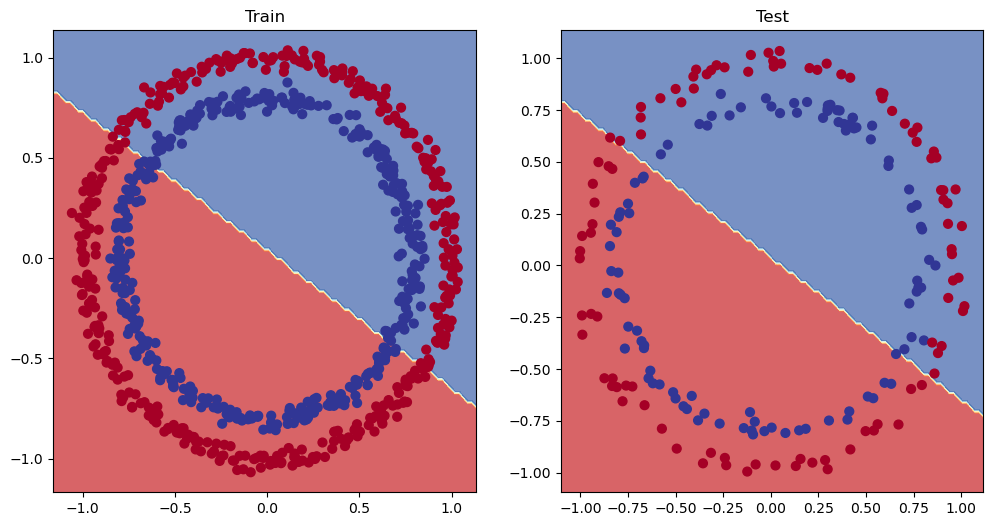

In [29]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model | [Chapter 73](https://youtu.be/V_xro1bcAuA&t=39476) 

Aside what is here, I have seen an example of this where the cartesian coordinates were converted to polar coordinates and then a single linear layer has no issue with this.

What to do when it doesn't learn, or how to improve accuraccy.
* Add more layers - give the model more params to use
* Add more hidden units... expand the hidden layer(s)
* Fit for longer - some data may need some time before loss starts to decrease
* Change the learning rate - play with it
* Change the loss function - SGD is fine for small things but it won't help when a piece is missing
* Change the Activation functions.... purely linear functions cannot work on a circle problem unless the coordinate system was changed.  Which leads to the next..
* change the way the data is presented. rpovide sigmoids and RELU's at places to scale the data in ways that makes a liner decision boundry possible.

   These options are from the model's perspective instead of a data perspective

Let's try and improve our model by:
* Adding more hidden units 5 -> 10
* Increase the number of layer 2 -> 3
* Increasing epochs 100 -> 1000

In [30]:
##Version 1
# Define some Hparms
IN_FEATURE_SIZE = 2
H1_FEATURE_SIZE = 5
H2_FEATURE_SIZE = 5
OUT_FEATURE_SIZE = 1
LEARN_RATE = 0.1
EPOCHS = 1000

class CircleModuleV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=IN_FEATURE_SIZE,
                               out_features=H1_FEATURE_SIZE)
        self.layer_2 = nn.Linear(in_features=H1_FEATURE_SIZE,
                               out_features=H2_FEATURE_SIZE)
        self.layer_3 = nn.Linear(in_features=H2_FEATURE_SIZE,
                               out_features=OUT_FEATURE_SIZE)
    # Setup the loss fcn and optimizer
    #loss_fcn = nn.BCELoss() # expects input to have passed thru a sigmoid layer first
    loss_fcn = nn.BCEWithLogitsLoss() # built in sigmoid function
    #loss_fcn = nn.L1Loss()
    
    optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=LEARN_RATE)
    def forward(self,x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [31]:
def plot_boundry(model, x_train, y_train, x_test, y_test):
    # Plot decision boundaries for training and test sets
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, x_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, x_test, y_test)

In [32]:
model_1 = CircleModuleV1().to(device)
model_1

CircleModuleV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=5, bias=True)
  (layer_3): Linear(in_features=5, out_features=1, bias=True)
)

In [33]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], device='cuda:0'),
 tensor([1., 0., 0., 0., 1.], device='cuda:0'))

In [34]:
#model and data to target device
model_1.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]], device='cuda:0')

In [35]:

for epoch in range(EPOCHS):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = model_1.loss_fcn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    model_1.optimizer.zero_grad()
    
    loss.backward()
    
    model_1.optimizer.step()
    # Test
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = model_1.loss_fcn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print
    if epoch % 100 == 0:
        #clear_output(True)
        #plt.close()
        #plot_boundry(model_0, X_train, y_train, X_test, y_test)
        print(f"EPOCH: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}%  | Test loss: {test_loss:.5f}, acc: {test_acc:.2f}%")
        # time.sleep(1)


EPOCH: 0 | Loss: 0.73890, Acc: 50.00%  | Test loss: 0.73709, acc: 50.00%
EPOCH: 100 | Loss: 0.73890, Acc: 50.00%  | Test loss: 0.73709, acc: 50.00%
EPOCH: 200 | Loss: 0.73890, Acc: 50.00%  | Test loss: 0.73709, acc: 50.00%
EPOCH: 300 | Loss: 0.73890, Acc: 50.00%  | Test loss: 0.73709, acc: 50.00%
EPOCH: 400 | Loss: 0.73890, Acc: 50.00%  | Test loss: 0.73709, acc: 50.00%
EPOCH: 500 | Loss: 0.73890, Acc: 50.00%  | Test loss: 0.73709, acc: 50.00%
EPOCH: 600 | Loss: 0.73890, Acc: 50.00%  | Test loss: 0.73709, acc: 50.00%
EPOCH: 700 | Loss: 0.73890, Acc: 50.00%  | Test loss: 0.73709, acc: 50.00%
EPOCH: 800 | Loss: 0.73890, Acc: 50.00%  | Test loss: 0.73709, acc: 50.00%
EPOCH: 900 | Loss: 0.73890, Acc: 50.00%  | Test loss: 0.73709, acc: 50.00%


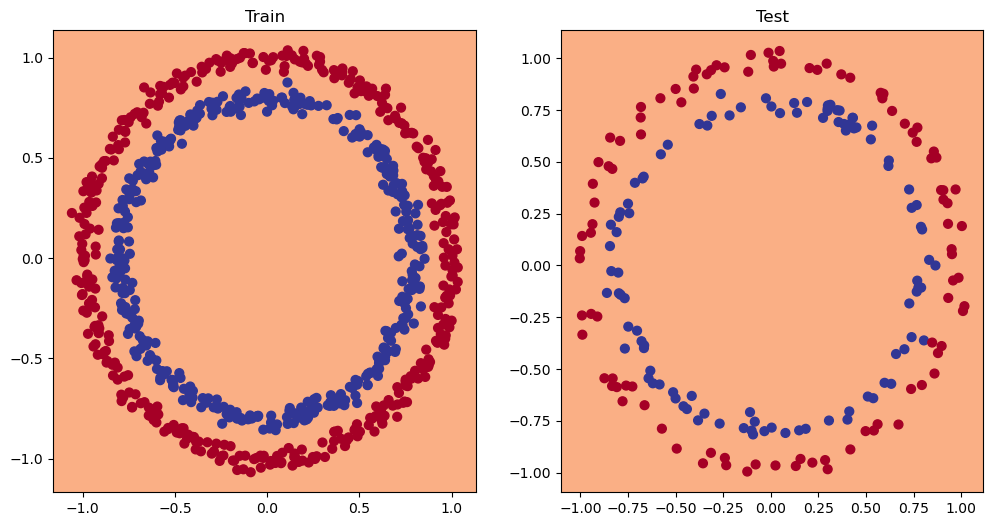

In [36]:
plot_boundry(model_1, X_train, y_train, X_test, y_test)

## 6. The missing piece: non-linearity | [Chapter 79](https://youtu.be/V_xro1bcAuA&t=42686) 


### 6.1 Recreating non linear data (red and blue circles)

In [37]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                  noise=0.02,
                  random_state=42)

#plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [38]:
# Convert data to tensors and then train and test split
import torch
from sklearn.model_selection import train_test_split

# tuen into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

# split
X_train,X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6483, -0.4748],
         [ 0.6464, -0.7356],
         [-1.0020, -0.1328],
         [-0.9692, -0.2252],
         [-0.1676,  0.7936]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity
* Linear = straight linear
* Non-linear = non.straight lines

In [86]:
# Define some Hparms
IN_FEATURE_SIZE = 2
H1_FEATURE_SIZE = 10
H2_FEATURE_SIZE = 10
OUT_FEATURE_SIZE = 1
LEARN_RATE = 0.1
EPOCHS = 2000


In [81]:
##Version 2
from torch import nn

class CircleModuleV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=IN_FEATURE_SIZE,
                               out_features=H1_FEATURE_SIZE)
        self.layer_2 = nn.Linear(in_features=H1_FEATURE_SIZE,
                               out_features=H2_FEATURE_SIZE)
        self.layer_3 = nn.Linear(in_features=H2_FEATURE_SIZE,
                               out_features=OUT_FEATURE_SIZE)
        self.relu = nn.ReLU()

#        self.relu = nn.Tanh()
    def forward(self,x):
        # where do we put the relu?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [82]:
model_2 = CircleModuleV2().to(device)
model_2

CircleModuleV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [83]:
# Setup the loss fcn and optimizer
#loss_fcn = nn.BCELoss() # expects input to have passed thru a sigmoid layer first
loss_fcn = nn.BCEWithLogitsLoss() # built in sigmoid function
#loss_fcn = nn.L1Loss() # used for linear regression
optimizer = torch.optim.SGD(params=model_2.parameters(),
                        lr=LEARN_RATE)

In [88]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#model and data to target device
model_2.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


In [89]:

for epoch in range(EPOCHS):
    model_2.train()
    y_logits = model_2(X_train).squeeze()
    
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fcn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    # Test
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fcn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print
    if epoch % 100 == 0:
        #clear_output(True)
        #plt.close()
        #plot_boundry(model_0, X_train, y_train, X_test, y_test)
        print(f"EPOCH: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}%  | Test loss: {test_loss:.5f}, acc: {test_acc:.2f}%")
        # time.sleep(1)


EPOCH: 0 | Loss: 0.01056, Acc: 100.00%  | Test loss: 0.01866, acc: 100.00%
EPOCH: 100 | Loss: 0.00988, Acc: 100.00%  | Test loss: 0.01765, acc: 100.00%
EPOCH: 200 | Loss: 0.00928, Acc: 100.00%  | Test loss: 0.01672, acc: 100.00%
EPOCH: 300 | Loss: 0.00876, Acc: 100.00%  | Test loss: 0.01594, acc: 100.00%
EPOCH: 400 | Loss: 0.00829, Acc: 100.00%  | Test loss: 0.01525, acc: 100.00%
EPOCH: 500 | Loss: 0.00787, Acc: 100.00%  | Test loss: 0.01463, acc: 100.00%
EPOCH: 600 | Loss: 0.00749, Acc: 100.00%  | Test loss: 0.01407, acc: 100.00%
EPOCH: 700 | Loss: 0.00715, Acc: 100.00%  | Test loss: 0.01356, acc: 100.00%
EPOCH: 800 | Loss: 0.00683, Acc: 100.00%  | Test loss: 0.01308, acc: 100.00%
EPOCH: 900 | Loss: 0.00654, Acc: 100.00%  | Test loss: 0.01265, acc: 100.00%
EPOCH: 1000 | Loss: 0.00628, Acc: 100.00%  | Test loss: 0.01224, acc: 100.00%
EPOCH: 1100 | Loss: 0.00603, Acc: 100.00%  | Test loss: 0.01186, acc: 100.00%
EPOCH: 1200 | Loss: 0.00580, Acc: 100.00%  | Test loss: 0.01151, acc: 100.00

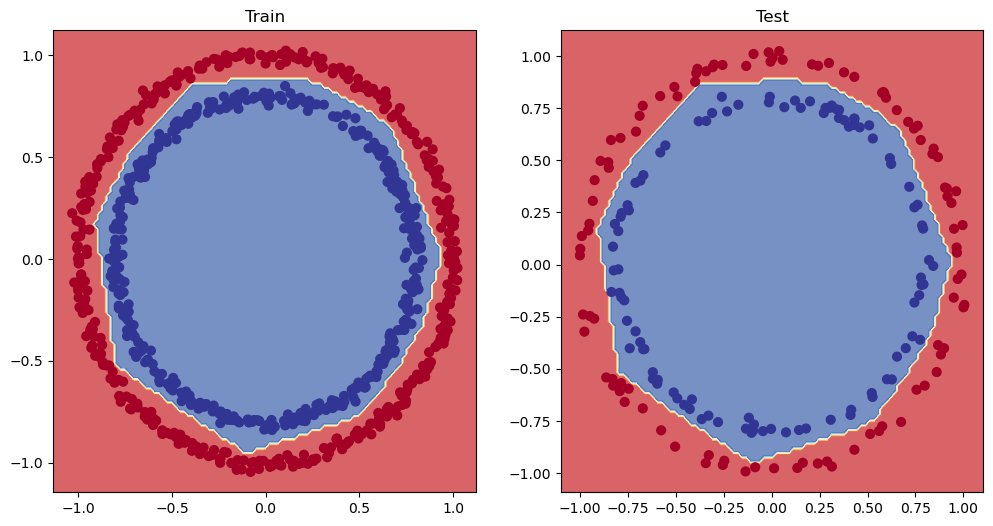

In [90]:
plot_boundry(model_2, X_train, y_train, X_test, y_test)

### 6.3 Evaluating a model trained with non-linear activation functions

In [46]:
model_2.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


In [47]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

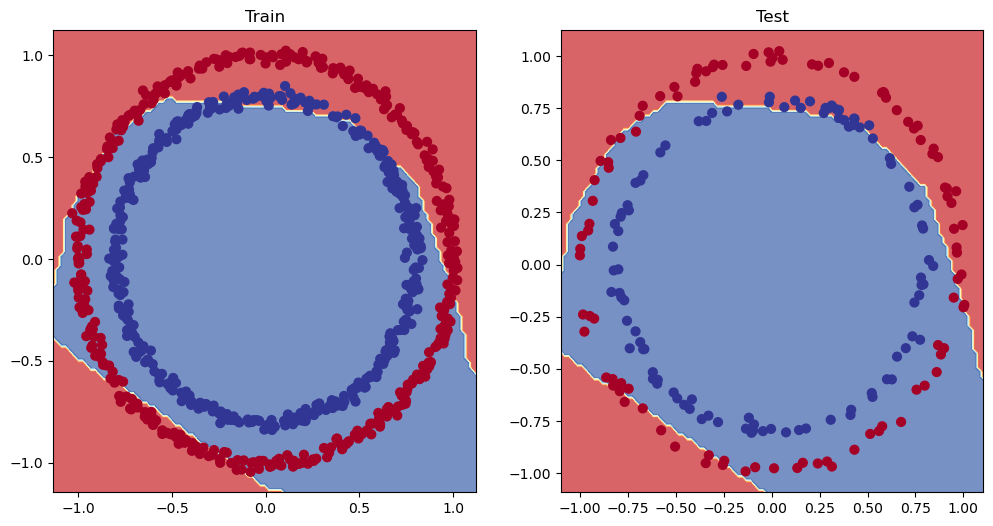

In [48]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

## 7. Replicating non_linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own

In [49]:
# create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype,A

(torch.float32,
 tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]))

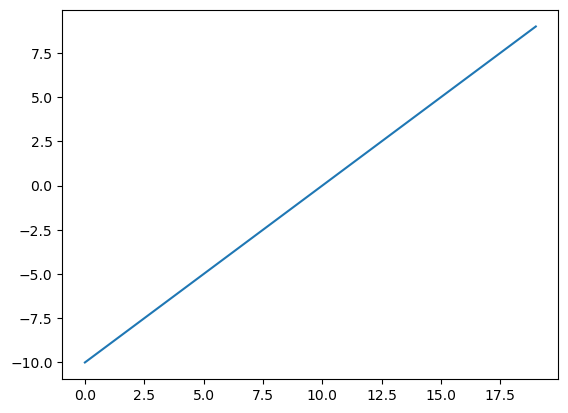

In [50]:
# visualize data
plt.plot(A)

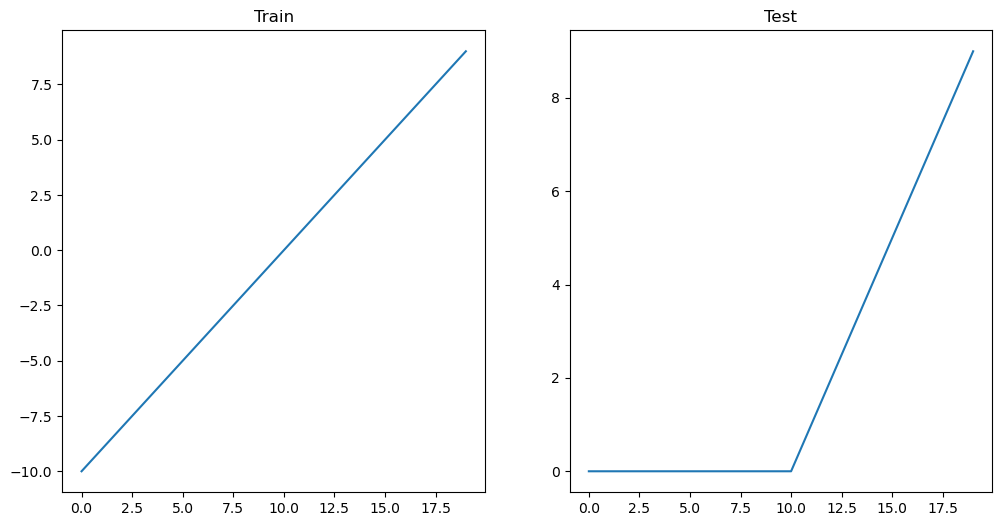

In [51]:
def myRelu(X: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0),A)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plt.plot(A);
plt.subplot(1,2,2)
plt.title("Test")
plt.plot(myRelu(A));

In [52]:
def mySigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1/(1 + torch.exp(-x))
A,mySigmoid(A)

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
         1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
         8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
         9.9966e-01, 9.9988e-01]))

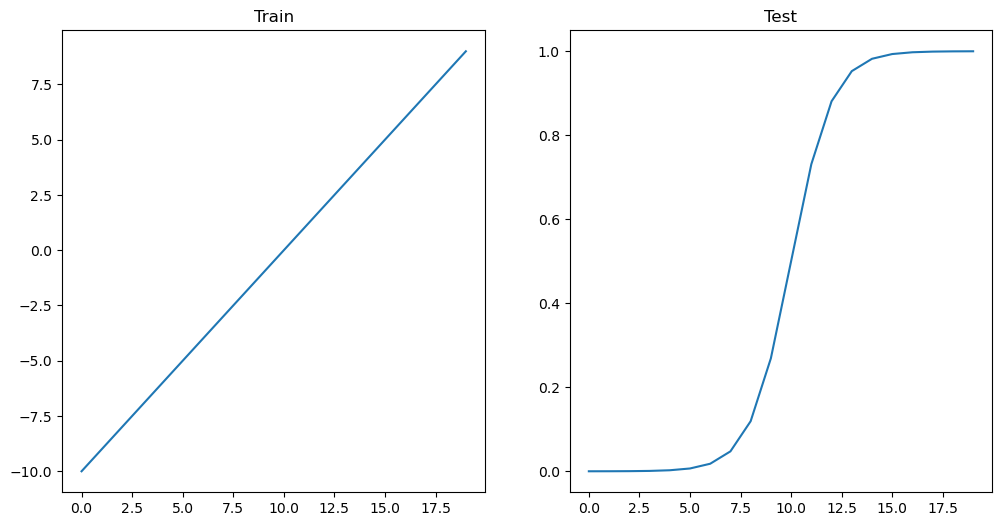

In [53]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plt.plot(A);
plt.subplot(1,2,2)
plt.title("Test")
plt.plot(mySigmoid(A));

## 8. Putting it all together with multi-class classification problem | [Chapter 84](https://youtu.be/V_xro1bcAuA&t=45752) 

* binary classification is one thing or another (cat/dog, spam/not spam, etc...)
* Multi-class classifications is several categories (cat/dog/chicken)

Differences between the two involve non linear functions
1. Activation function:  torch.sigmoid - torch.Softmax
2. Loss function: torch.nn.BCE (WithLogits) Loss - torch.nn.CrossEntropyLoss 

### 8.1 Creating our toy multi-class dataset
[Sklearn make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)

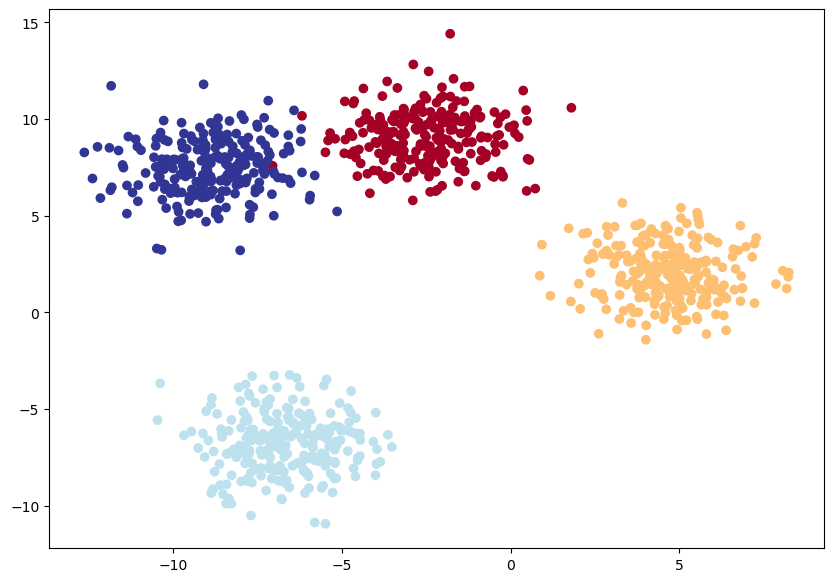

In [54]:
#import dependencies
import torch
import matplotlib.pyplot as  plt
from sklearn.datasets import make_blobs 
from sklearn.model_selection import train_test_split

# setup HParms
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create the multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.4, # give the clusters a little shakeup
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test ,y_blob_train, y_blob_test = train_test_split(X_blob,
                               y_blob,
                               test_size=0.2,
                               random_state=RANDOM_SEED)
X_blob_train.shape, X_blob_train[:2], y_blob_train.shape, y_blob_train[:3]


# 4. plot data
plt.figure(figsize = (10, 7))

plt.scatter(x=X_blob[:, 0], y=X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [108]:
def plot_model_decision_boundries(model, x_train, y_train, x_test, y_test):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Train")
    plot_decision_boundary(model, x_train, y_train)
    plt.subplot(1,2,2)
    plt.title("Test")
    plot_decision_boundary(model, x_test, y_test)
    model.to(device)
    x_train, y_train = x_train.to(device), y_train.to(device)
    x_test, y_test = x_test.to(device), y_test.to(device)


### 8.2 Building a multi-class classification model

In [211]:

# Define some Hparms
LEARN_RATE = 0.1
EPOCHS = 100

# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [223]:
# Build a multi-class classification model
class BlobModelV1(nn.Module):
    def __init__(self, in_features: int, 
                out_features: int, hidden_units: int =8):
        """ Initializes a multi-class classification model
        Args:
            in_features (int): number of input features
            out_features (int): Number of output features (classes)
            hidden_units (int): depth of hidden layer(s)
            
        Returns:
        Example:
        """
        super().__init__()
        self.linear_stack_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )

    def forward(self, x):
        return self.linear_stack_layer(x)

# 2 inputs and 2 outputs (1/per category)
blob_model = BlobModelV1(in_features=NUM_FEATURES, 
                         out_features=NUM_CLASSES,
                        hidden_units=8).to(device) 
blob_model

BlobModelV1(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss and optimizer for multi-class Pytorch model

In [224]:
# define loss and optimizer
loss_fn_CE = torch.nn.CrossEntropyLoss()
optimizerSGD = torch.optim.SGD(blob_model.parameters(),
                        lr=LEARN_RATE)
 

### 8.4 Getting prediction probabilities for multi-class Pytorch model

In [214]:
# Perform a single forward pass on the data 
# (we'll need to put it to the target device for it to work)

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)
blob_model(X_blob_train)[:5]

tensor([[-1.2588, -0.6376, -1.4588, -0.7035],
        [ 0.2213, -1.5392,  0.0430,  1.1498],
        [ 2.8335,  0.8957,  3.2742,  1.3879],
        [ 1.9821,  0.3340,  2.2545,  1.1356],
        [ 0.5244, -1.2538,  0.4183,  1.1753]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [199]:
# How many elements in a single prediction sample?
blob_model(X_blob_train[0]).shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [200]:
# try a basic test
test_logits = blob_model(X_blob_test)

# turn raw logits to prediction probabilities
test_pred_probs = torch.softmax(test_logits, dim=1)
print(test_logits[:5])
print(test_pred_probs[:5])

tensor([[ 0.8162, -0.8633, -0.2843,  0.4318],
        [-0.9437, -2.0746,  0.9638, -2.2944],
        [-0.6798, -0.0805,  0.8106, -1.3232],
        [ 0.6945, -0.5330, -0.1903,  0.3719],
        [ 0.1213, -1.9425,  0.1972, -0.8310]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.4545, 0.0848, 0.1512, 0.3095],
        [0.1202, 0.0388, 0.8098, 0.0311],
        [0.1285, 0.2339, 0.5702, 0.0675],
        [0.4115, 0.1206, 0.1699, 0.2980],
        [0.3859, 0.0490, 0.4163, 0.1489]], device='cuda:0',
       grad_fn=<SliceBackward0>)


The softmax takes the raw logits and turns them into probabilities
The sum of each row is one and each element is the probability precentage 

In [201]:
# Sum the first sample output of the softmax activation function 
print(f"Sum of first row: {torch.sum(test_pred_probs[0])}")
pct = (100 * test_pred_probs[0])
print(f"{pct[0].item():.2F} %")
#print(pct[:4])
for i, percent in enumerate(pct):
    print (f"Percentage {i}: {percent.item():.2F} %")
print(f"Total of percentages = {torch.sum(pct)} ")

Sum of first row: 1.0
45.45 %
Percentage 0: 45.45 %
Percentage 1: 8.48 %
Percentage 2: 15.12 %
Percentage 3: 30.95 %
Total of percentages = 100.0 


In [202]:

# calculate the loss
try:
    test_loss = loss_fn_CE(test_logits, y_blob_test)
    print("Test Loss:", test_loss.item())
except Exception as e:
    print(f"Error calculating loss: {e}")

# Convert probabilities to labels
test_pred = torch.argmax(test_pred_probs,dim=1)
test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

print( test_logits.shape, test_logits[0])
print(y_blob_test.shape, y_blob_test[0])
print(f"Test loss: {test_loss:.5f}, acc: {test_acc:.2f}%")


Test Loss: 1.943234920501709
torch.Size([200, 4]) tensor([ 0.8162, -0.8633, -0.2843,  0.4318], device='cuda:0',
       grad_fn=<SelectBackward0>)
torch.Size([200]) tensor(1, device='cuda:0')
Test loss: 1.94323, acc: 27.00%


### 8.5 Creating a training and test loop for Multi-class PyTorch model

In [225]:
# Create test loop
# set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
EPOCHS = 100

# get all to device
blob_model.to(device)
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Test loop 
for epoch in range(EPOCHS):
    blob_model.train()

    # forward pass
    train_logits = blob_model(X_blob_train)

    # turn raw logits to prediction probabilities
    y_train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

    train_loss = loss_fn_CE(train_logits, y_blob_train)
    #print(loss.item())
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_train_preds)

    optimizerSGD.zero_grad()
    train_loss.backward()
    optimizerSGD.step()
    
    # Test
    blob_model.eval()
    with torch.inference_mode():
        test_logits = blob_model(X_blob_test)
        test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
        test_loss = loss_fn_CE(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    # print
    if epoch % 10 == 0:
        #clear_output(True)
        #plt.close()
        #plot_boundry(model_0, X_train, y_train, X_test, y_test)
        print(f"EPOCH: {epoch} | Loss: {train_loss:.5f}, Acc: {acc:.2f}%  | Test loss: {test_loss:.5f}, acc: {test_acc:.2f}%")
        # time.sleep(1)



EPOCH: 0 | Loss: 1.04179, Acc: 66.50%  | Test loss: 0.57534, acc: 96.00%
EPOCH: 10 | Loss: 0.13597, Acc: 99.50%  | Test loss: 0.12300, acc: 100.00%
EPOCH: 20 | Loss: 0.07245, Acc: 99.50%  | Test loss: 0.06500, acc: 99.50%
EPOCH: 30 | Loss: 0.05128, Acc: 99.50%  | Test loss: 0.04457, acc: 99.50%
EPOCH: 40 | Loss: 0.04112, Acc: 99.50%  | Test loss: 0.03451, acc: 99.50%
EPOCH: 50 | Loss: 0.03526, Acc: 99.50%  | Test loss: 0.02860, acc: 99.50%
EPOCH: 60 | Loss: 0.03147, Acc: 99.50%  | Test loss: 0.02472, acc: 99.50%
EPOCH: 70 | Loss: 0.02884, Acc: 99.50%  | Test loss: 0.02198, acc: 99.50%
EPOCH: 80 | Loss: 0.02691, Acc: 99.50%  | Test loss: 0.01995, acc: 99.50%
EPOCH: 90 | Loss: 0.02545, Acc: 99.50%  | Test loss: 0.01838, acc: 99.50%


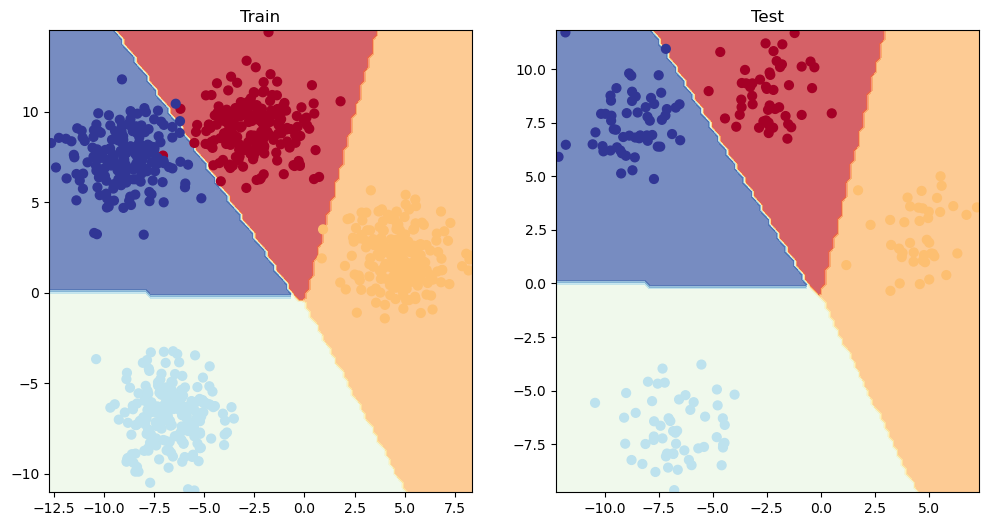

In [226]:
plot_model_decision_boundries(blob_model, X_blob_train, y_blob_train, X_blob_test,y_blob_test)

### [Chapter 88](https://youtu.be/V_xro1bcAuA&t=49160) 


## 9. More classification evaluation metrics

So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate your classification model using more metrics such as the following:

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/), especially the [TorchMetrics classification section](https://torchmetrics.readthedocs.io/en/stable/pages/classification.html). 

Let's try the `torchmetrics.Accuracy` metric out.




In [227]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Exercises

All of the exercises are focused on practicing the code in the sections above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agonistic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

Resources:
* [Exercise template notebook for 02](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb)
* [Example solutions notebook for 02](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/02_pytorch_classification_exercise_solutions.ipynb) (try the exercises *before* looking at this)

1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
    * For consistency, the dataset should have 1000 samples and a `random_state=42`.
    * Turn the data into PyTorch tensors. Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.
2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
    * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.
3. Setup a binary classification compatible loss function and optimizer to use when training the model.
4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
    * To measure model accuracy, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
    * Train the model for long enough for it to reach over 96% accuracy.
    * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.
5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.
6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
    * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.
7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
    * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
    * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
    * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
    * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

```python
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()
```

## Extra-curriculum

* Write down 3 problems where you think machine classification could be useful (these can be anything, get creative as you like, for example, classifying credit card transactions as fraud or not fraud based on the purchase amount and purchase location features). 
* Research the concept of "momentum" in gradient-based optimizers (like SGD or Adam), what does it mean?
* Spend 10-minutes reading the [Wikipedia page for different activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions), how many of these can you line up with [PyTorch's activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)?
* Research when accuracy might be a poor metric to use (hint: read ["Beyond Accuracy" by Will Koehrsen](https://willkoehrsen.github.io/statistics/learning/beyond-accuracy-precision-and-recall/) for ideas).
* **Watch:** For an idea of what's happening within our neural networks and what they're doing to learn, watch [MIT's Introduction to Deep Learning video](https://youtu.be/7sB052Pz0sQ).